In [1]:
import json

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [19]:
with open('result.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data['messages'])
df['msg_type'] = df['text_entities'].apply(lambda x: x[0]['type'] if isinstance(x, list) and len(x) > 0 else None)

In [3]:
df = df[['from', 'date', 'date_unixtime', 'text', 'msg_type', 'from_id']]

In [4]:
df = df.dropna(subset=['from'])

In [5]:
df['from'].unique()

array(['Мотюша', 'Никита', 'Илья Бибизянов', 'Няма Нямочкин', 'ТимохаПро',
       'Анёна', 'паша', '/'], dtype=object)

In [6]:
df['from'] = df['from'].str.replace('/', 'паша')

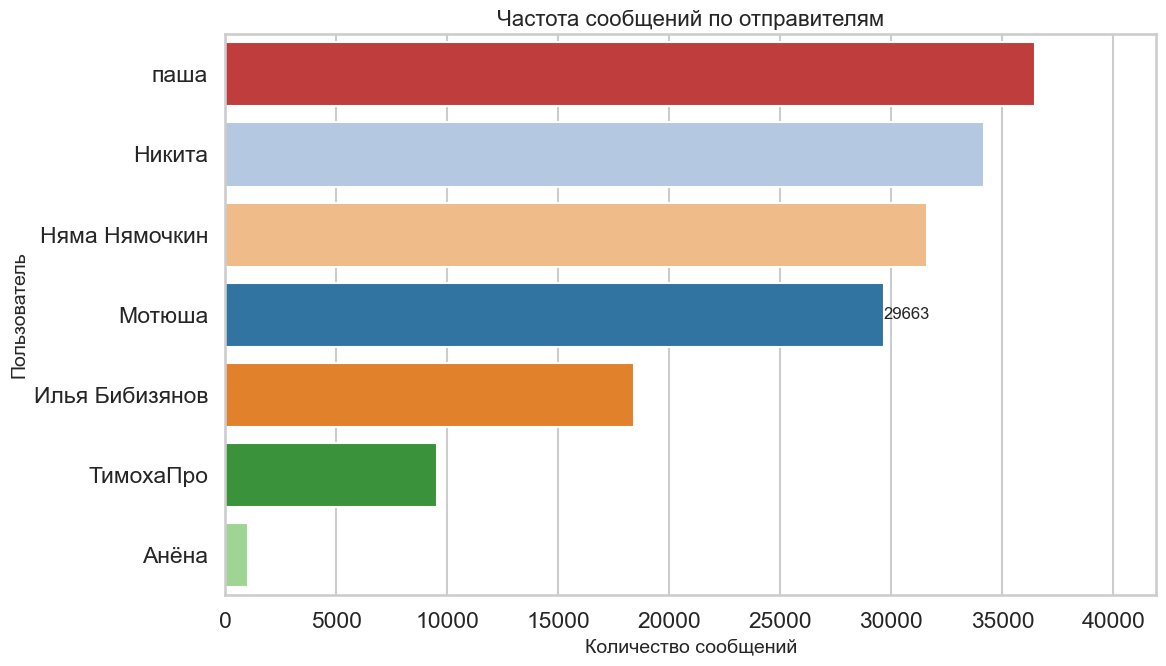

In [7]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
sns.set_context("talk")

ax = sns.countplot(
    y='from',
    hue='from',
    data=df,
    order=df['from'].value_counts().index,
    dodge=False,
    legend=False,
    palette='tab20'
)

for bar in ax.containers[0]:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.5, y, str(int(width)), va='center', ha='left', fontsize=12)

plt.xlabel('Количество сообщений', fontsize=14)
plt.ylabel('Пользователь', fontsize=14)
plt.title('Частота сообщений по отправителям', fontsize=16)
plt.xlim(0, df['from'].value_counts().max() * 1.15)
plt.tight_layout()
plt.show()


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
df['hour'] = df['date'].dt.hour

df['day'] = df['date'].dt.day

df['month'] = df['date'].dt.month

df['weekday_en'] = df['date'].dt.day_name()

df['weekday_num'] = df['date'].dt.weekday

weekday_ru_map = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

df['weekday_ru'] = df['weekday_en'].map(weekday_ru_map)


In [9]:
df = df[df['date'] < '2025-12-01']

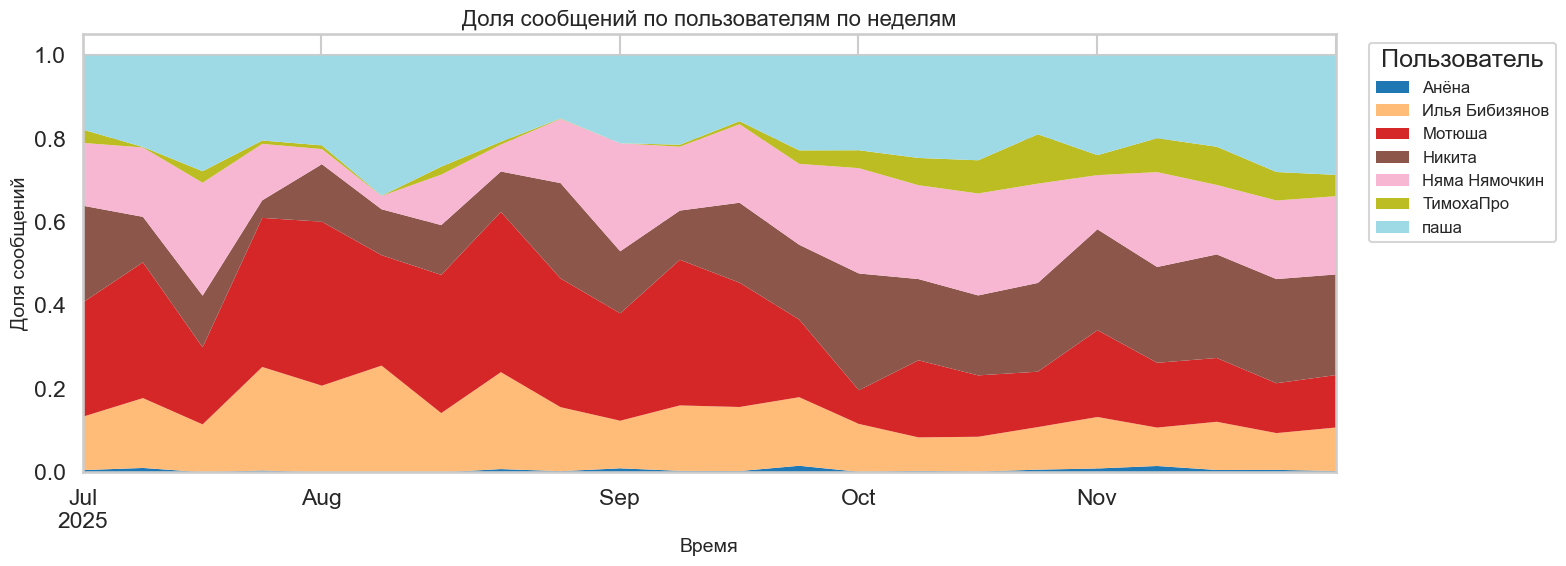

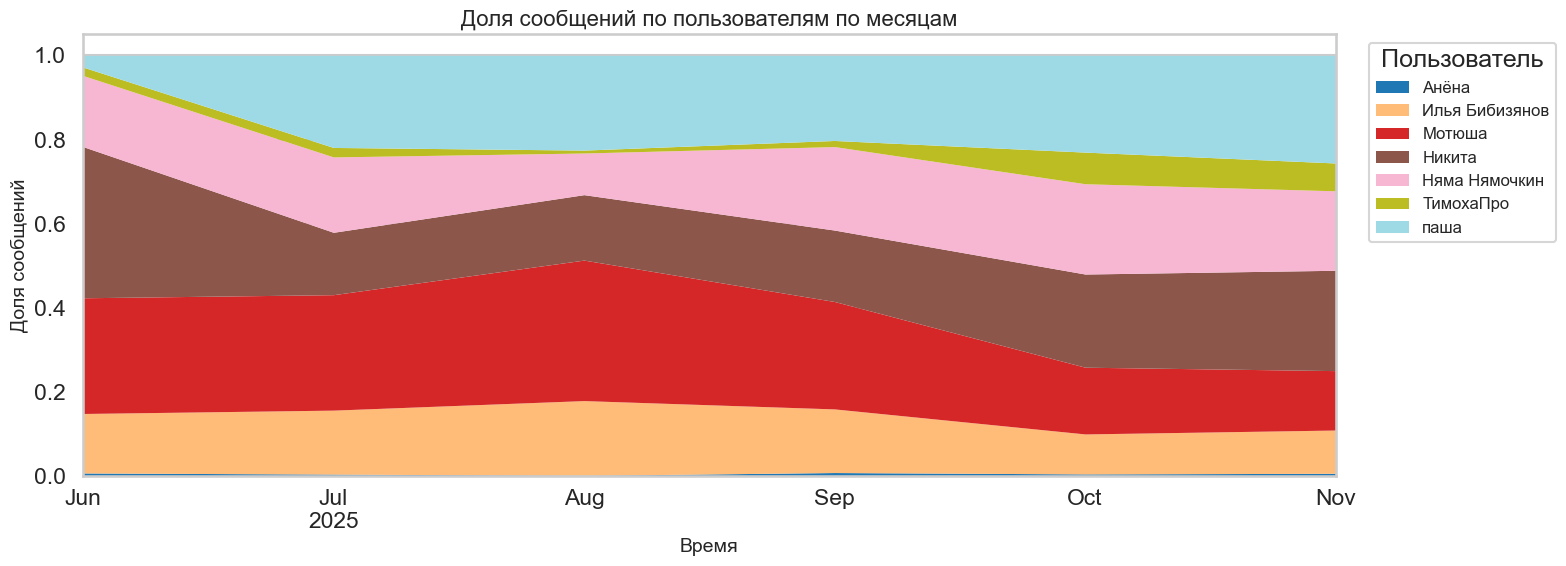

In [10]:
def plot_user_share(df, freq, title):
    sns.set_style("whitegrid")
    sns.set_context("talk")

    grouped = df.groupby([pd.Grouper(key='date', freq=freq), 'from']).size().unstack(fill_value=0)
    grouped_pct = grouped.div(grouped.sum(axis=1), axis=0)

    ax = grouped_pct.plot(
        kind='area',
        figsize=(16, 6),
        cmap='tab20',
        linewidth=0
    )

    plt.ylabel('Доля сообщений', fontsize=14)
    plt.xlabel('Время', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(title='Пользователь', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()


# Примеры
plot_user_share(df, 'W', 'Доля сообщений по пользователям по неделям')
plot_user_share(df, 'ME', 'Доля сообщений по пользователям по месяцам')


# Красные точки на графиках это дни, когда 0 сообщений

**************
*** Мотюша ***
**************


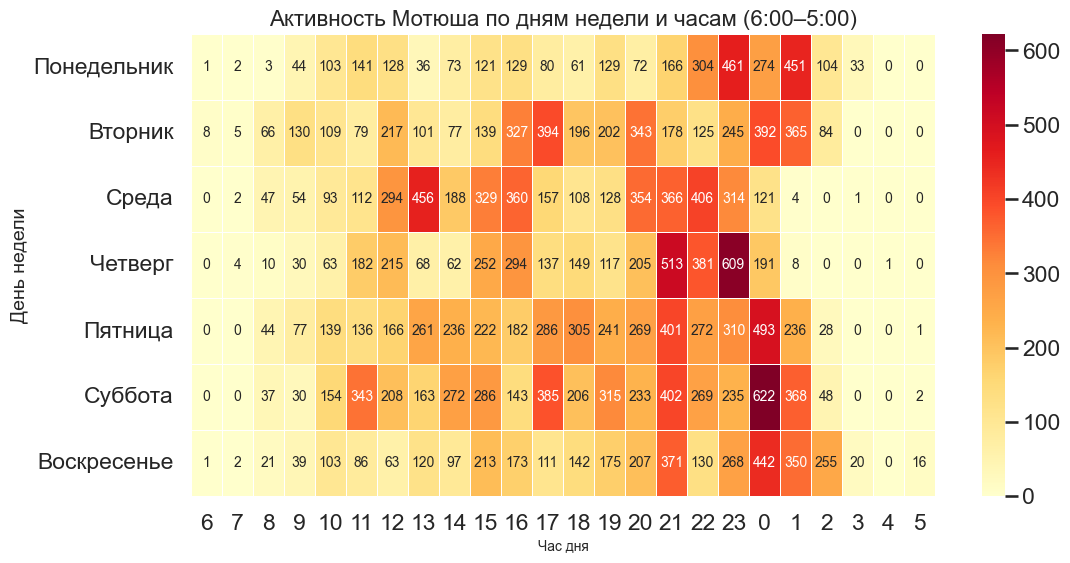

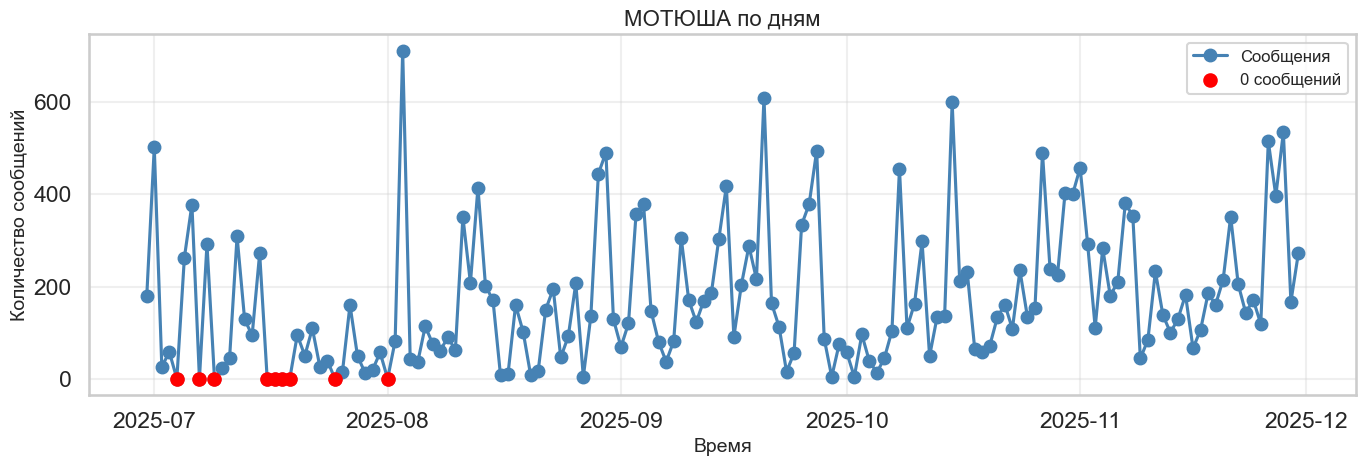

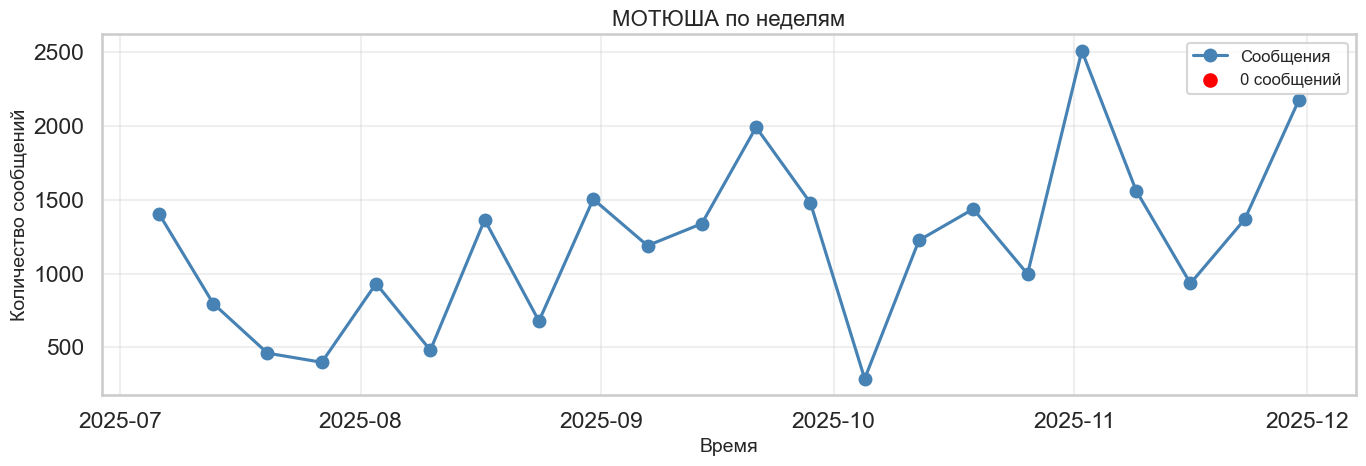

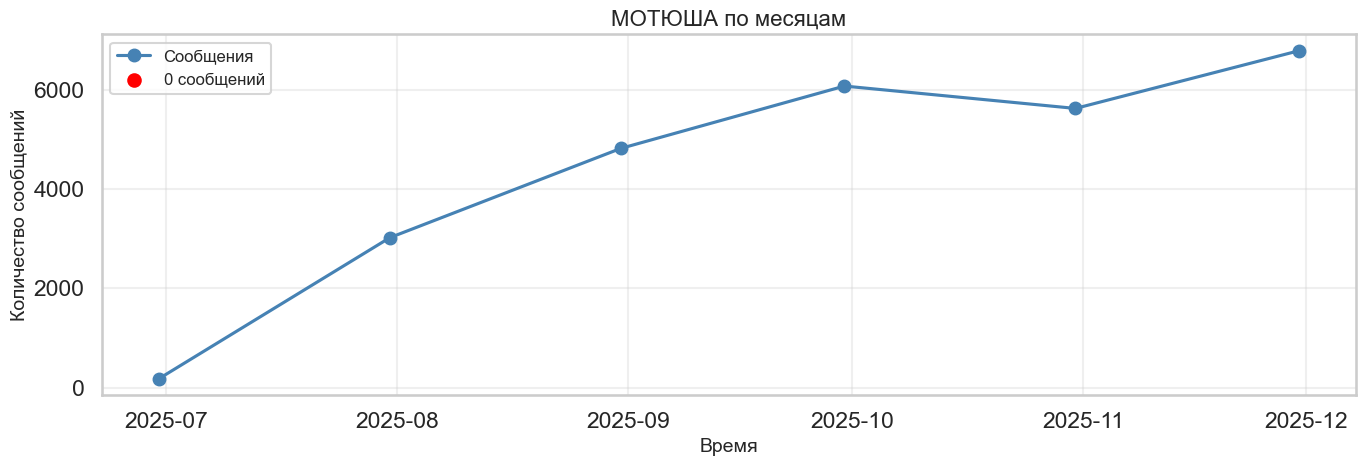

**************
*** Никита ***
**************


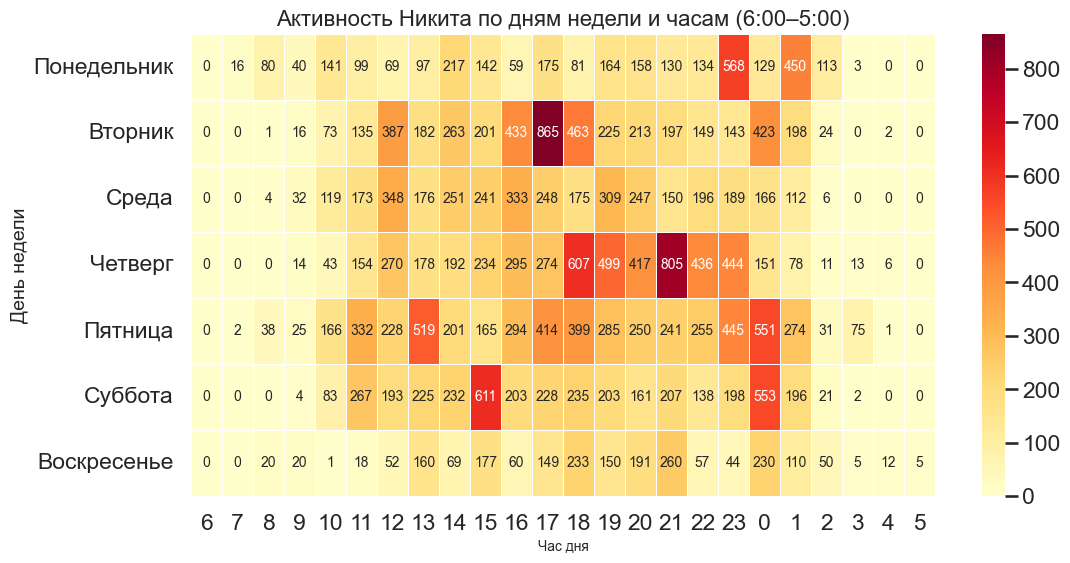

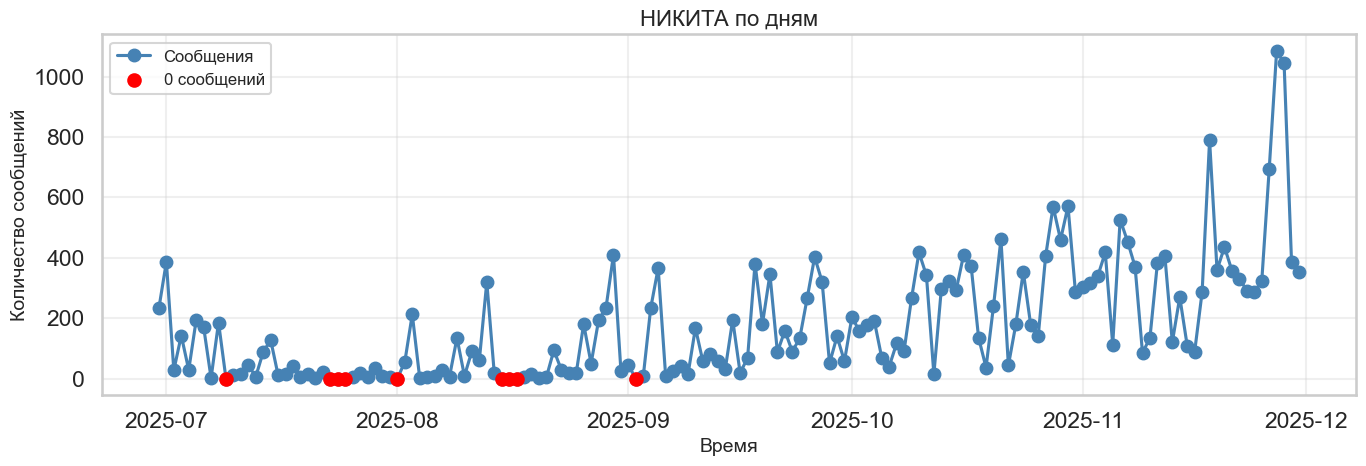

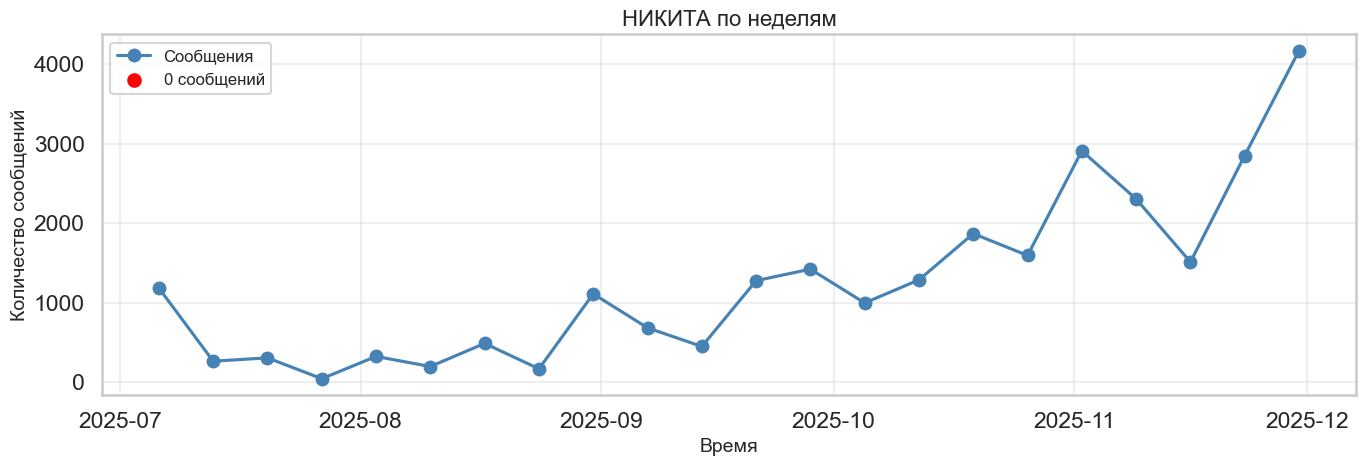

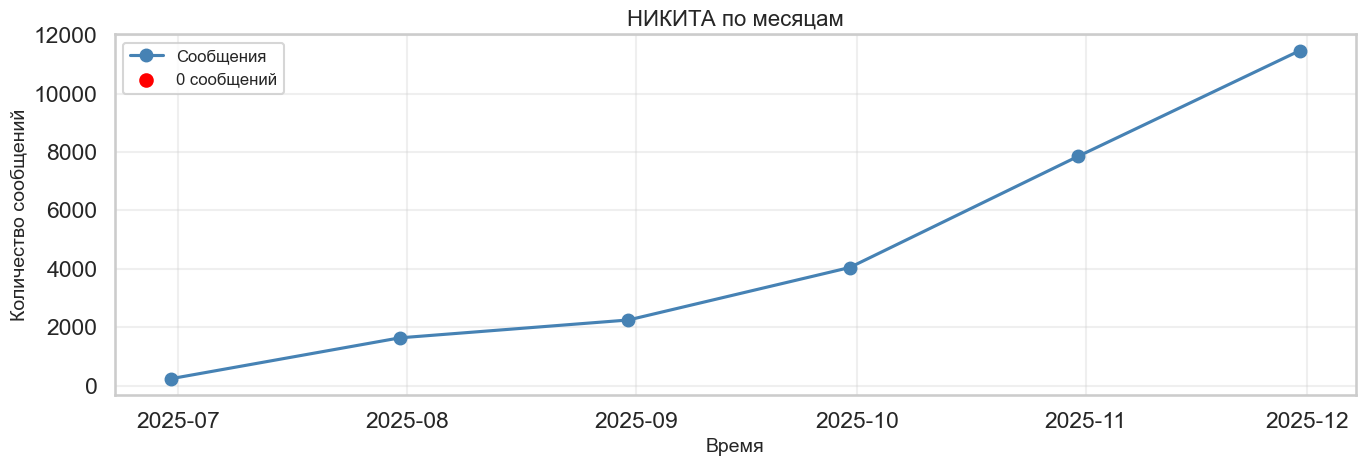

**********************
*** Илья Бибизянов ***
**********************


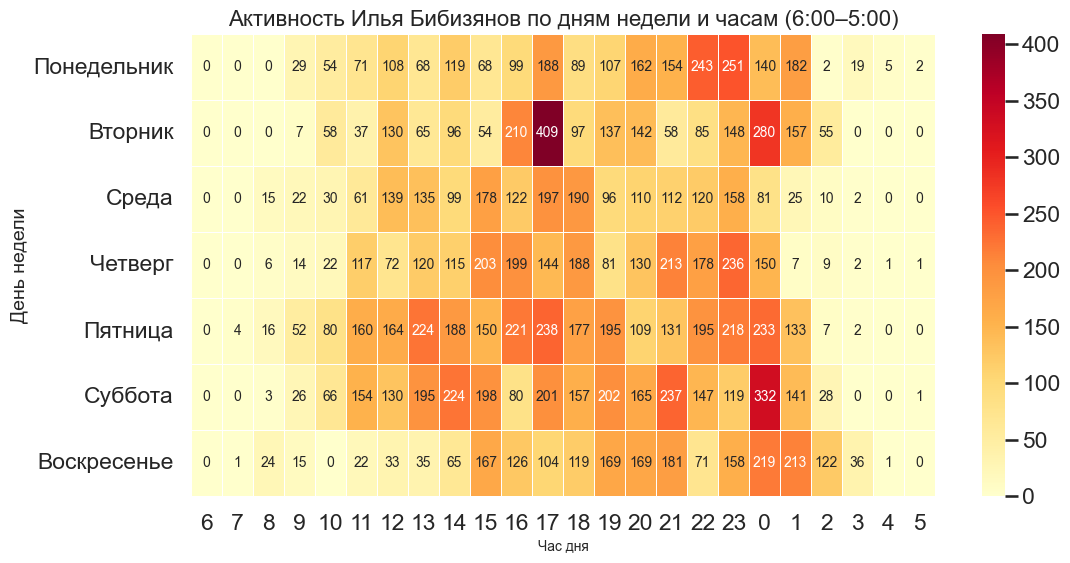

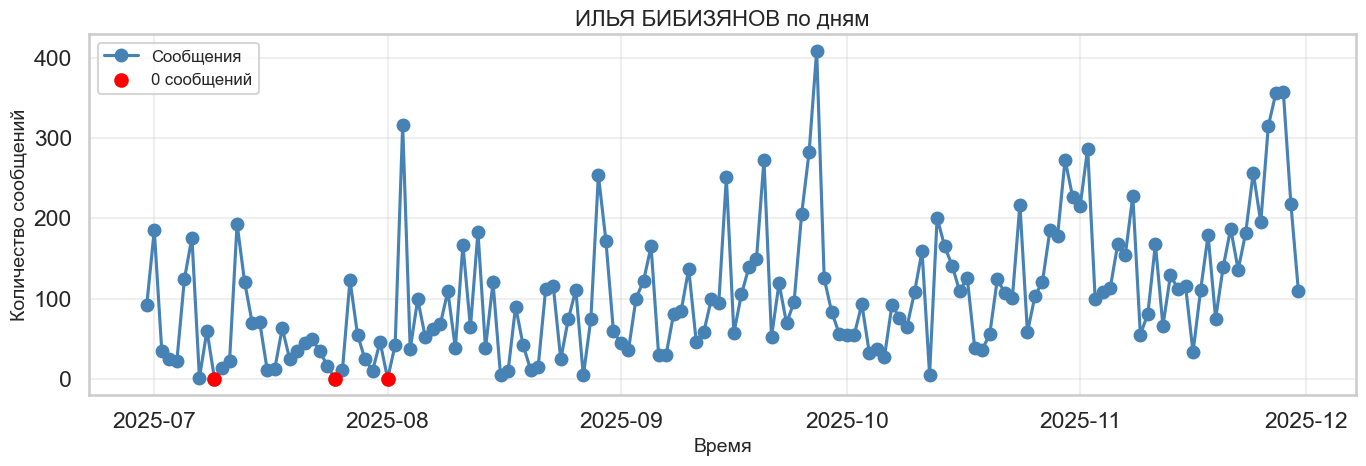

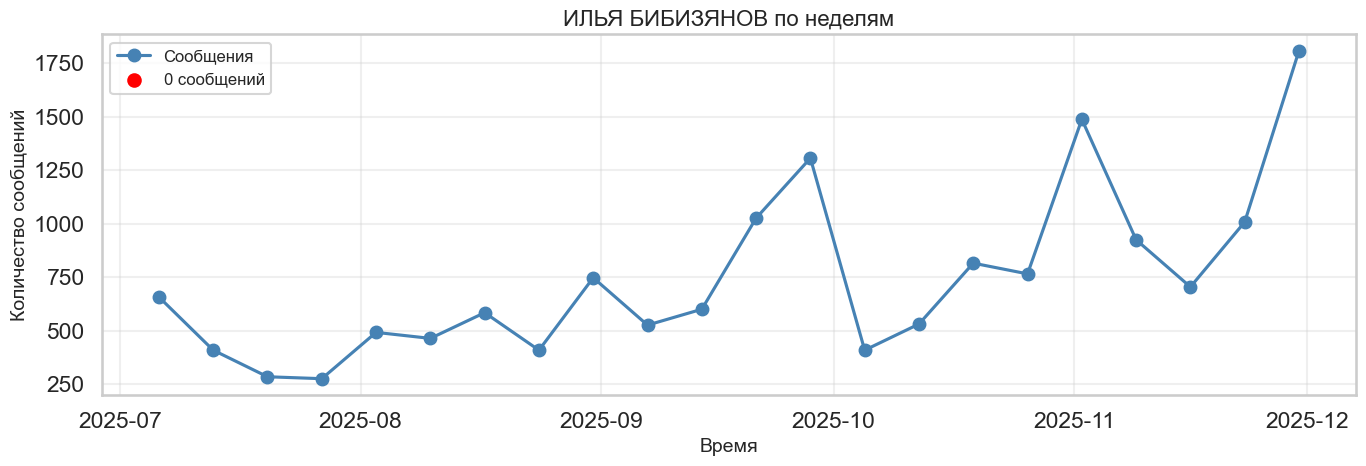

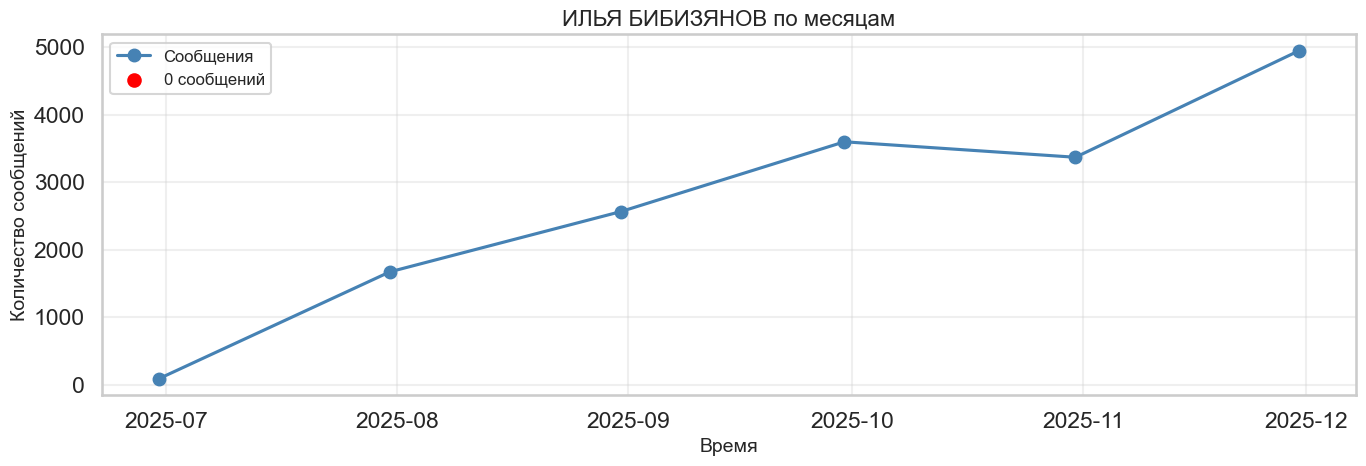

*********************
*** Няма Нямочкин ***
*********************


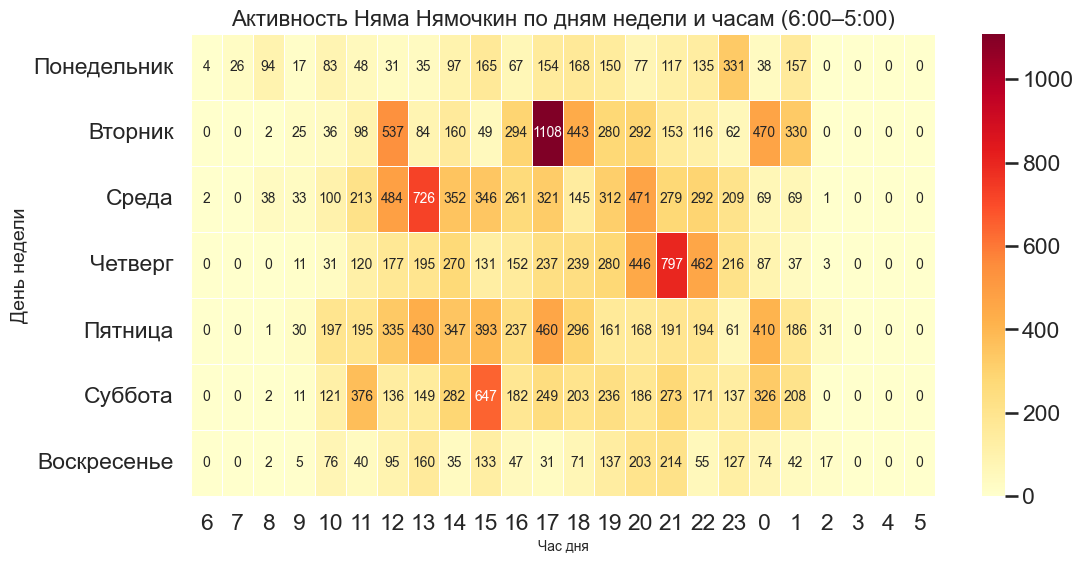

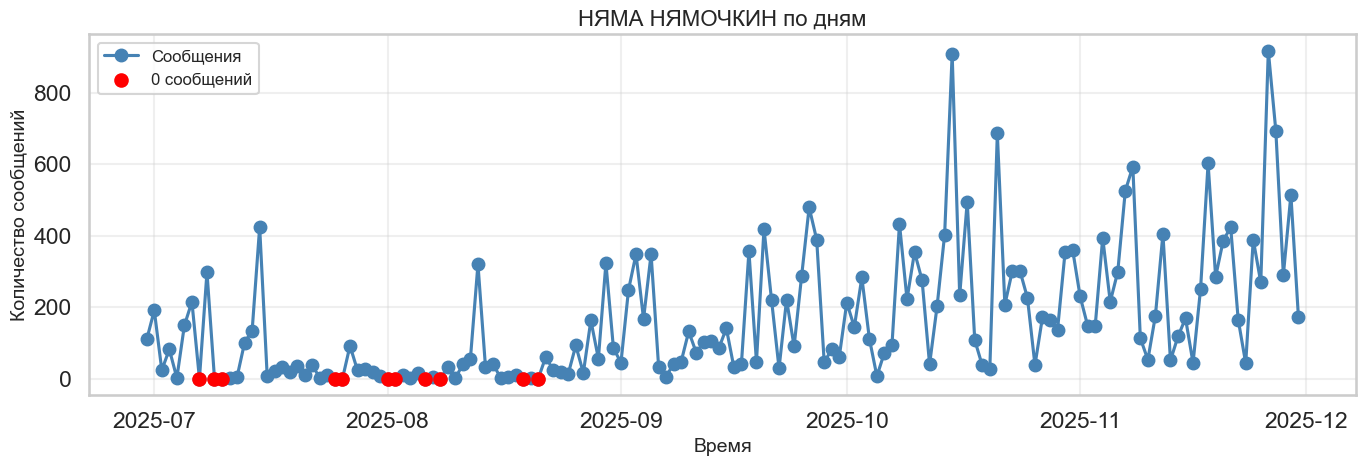

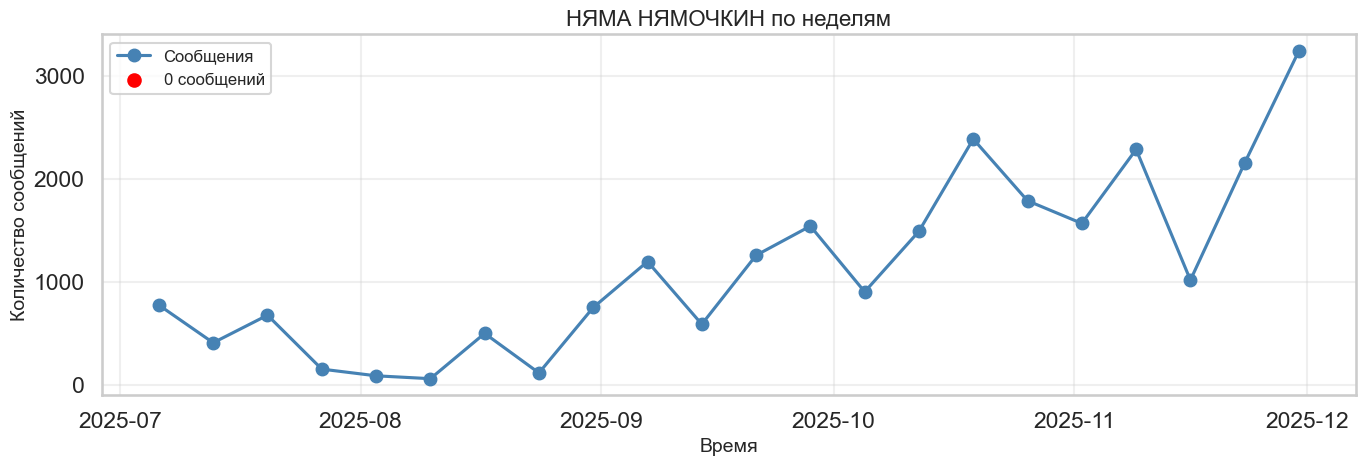

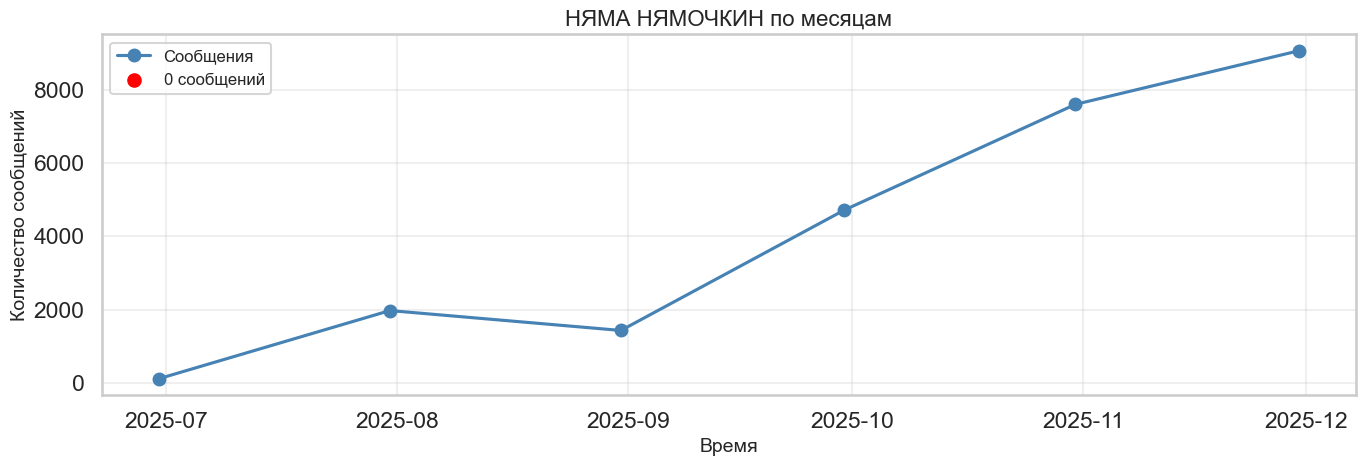

*****************
*** ТимохаПро ***
*****************


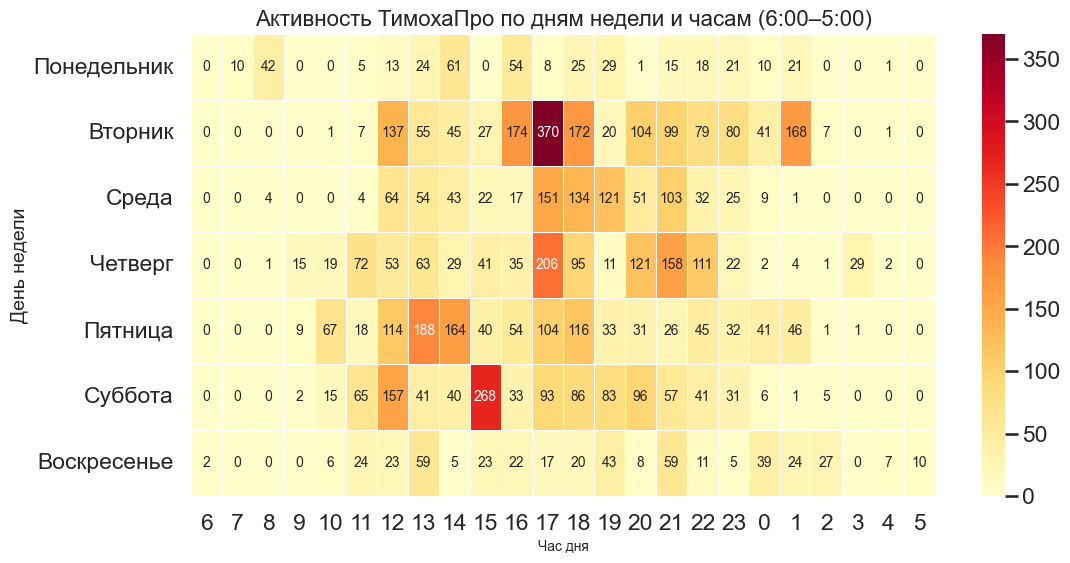

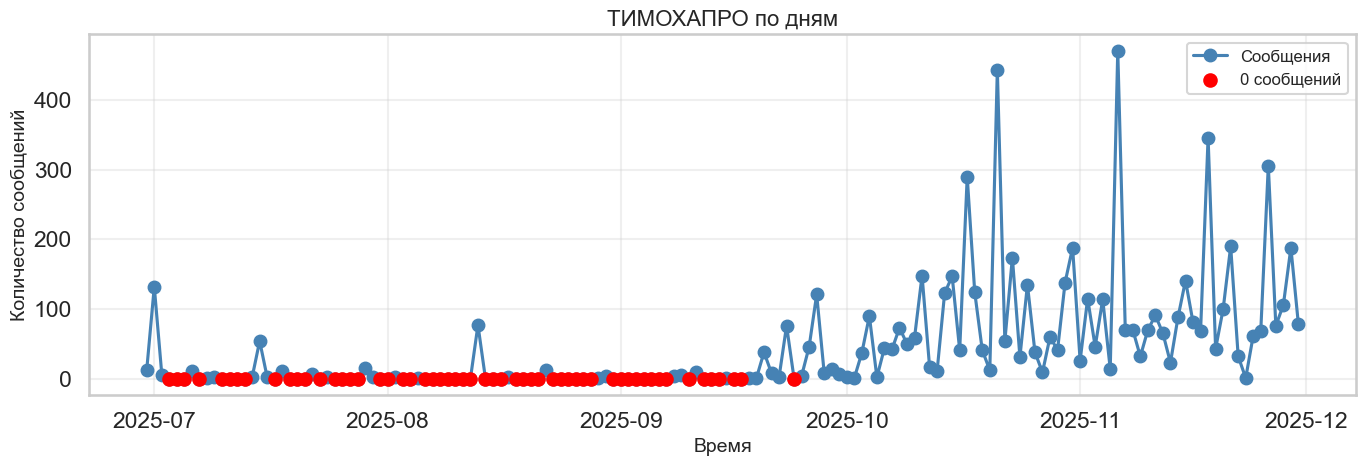

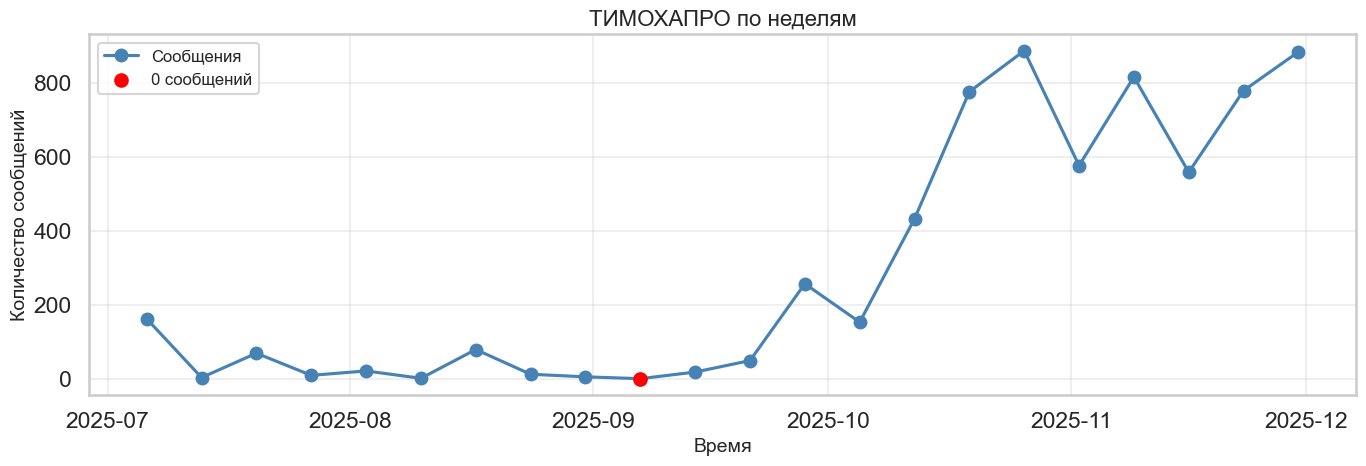

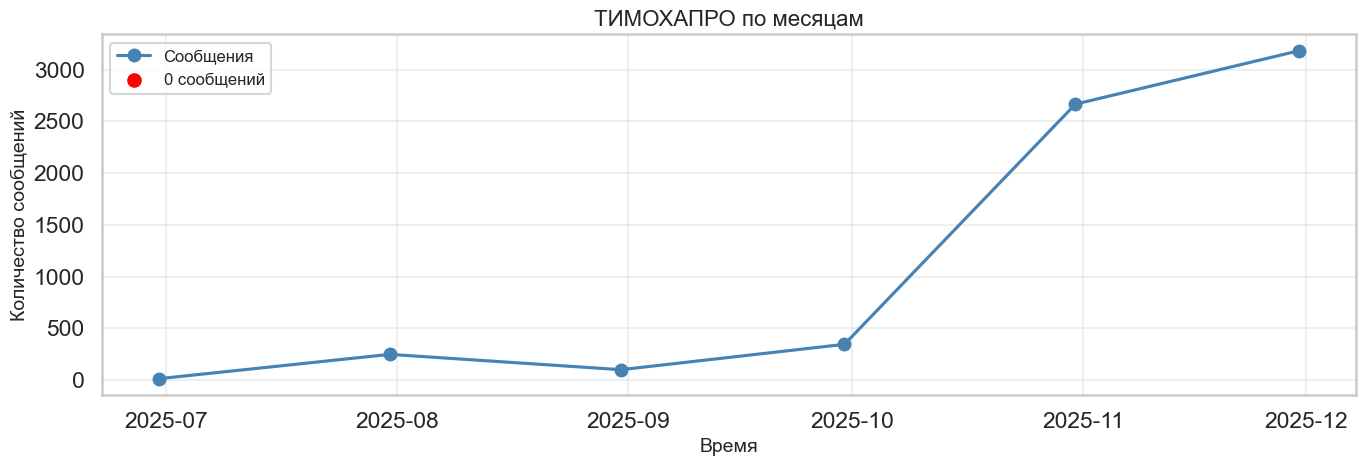

*************
*** Анёна ***
*************


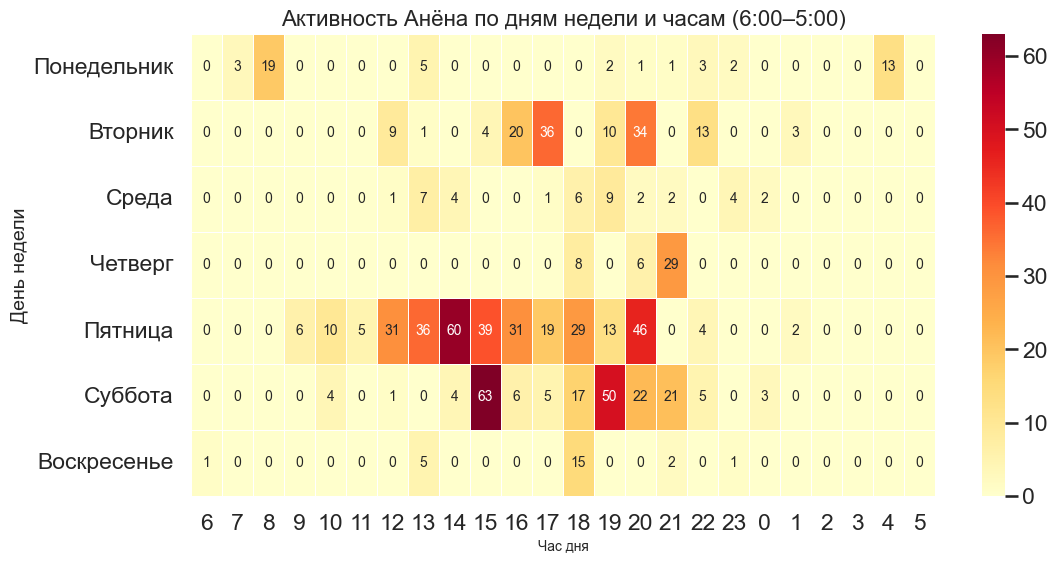

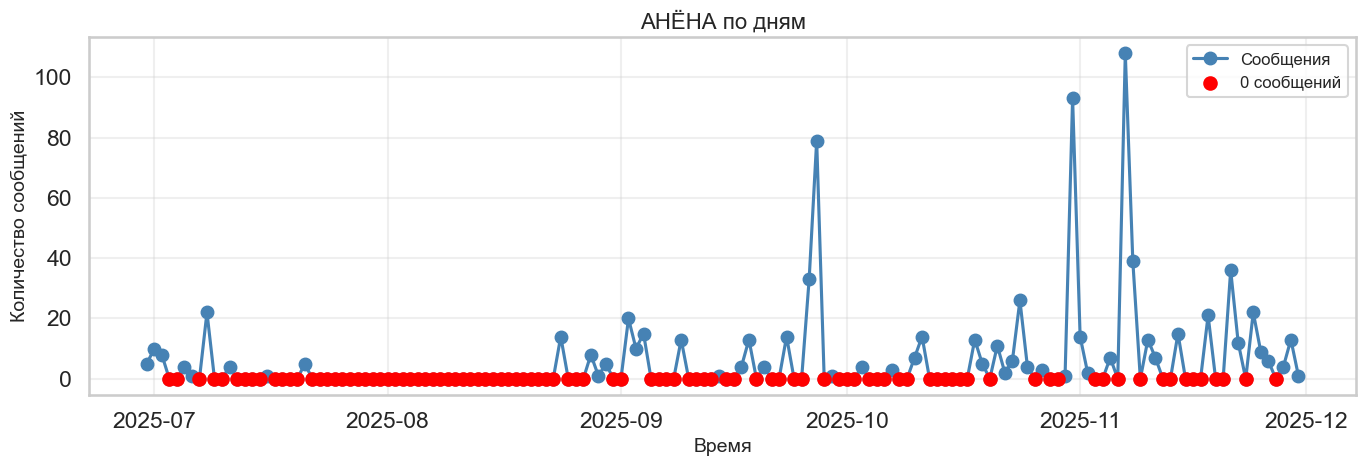

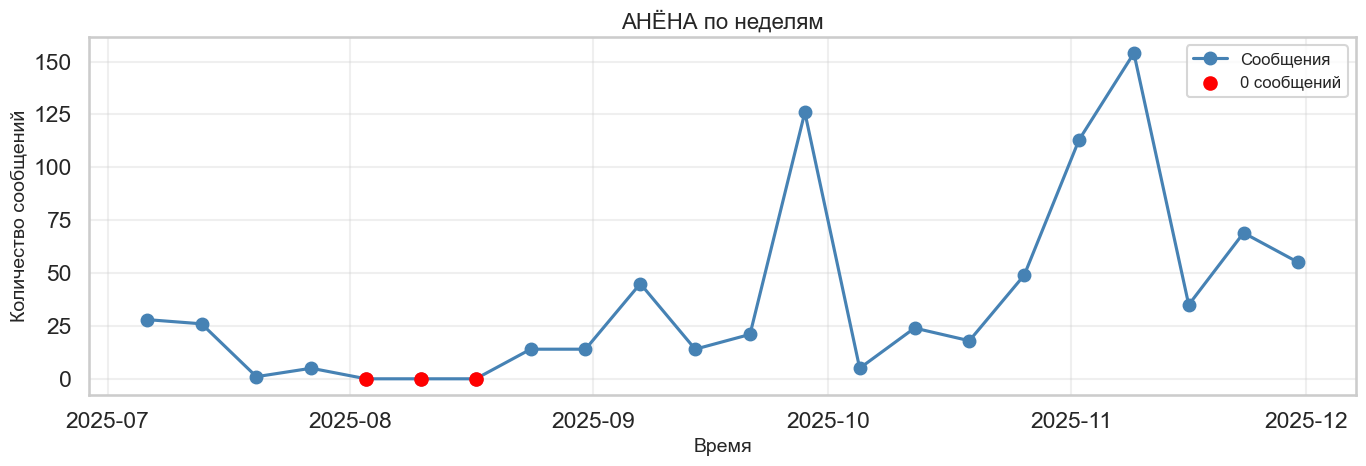

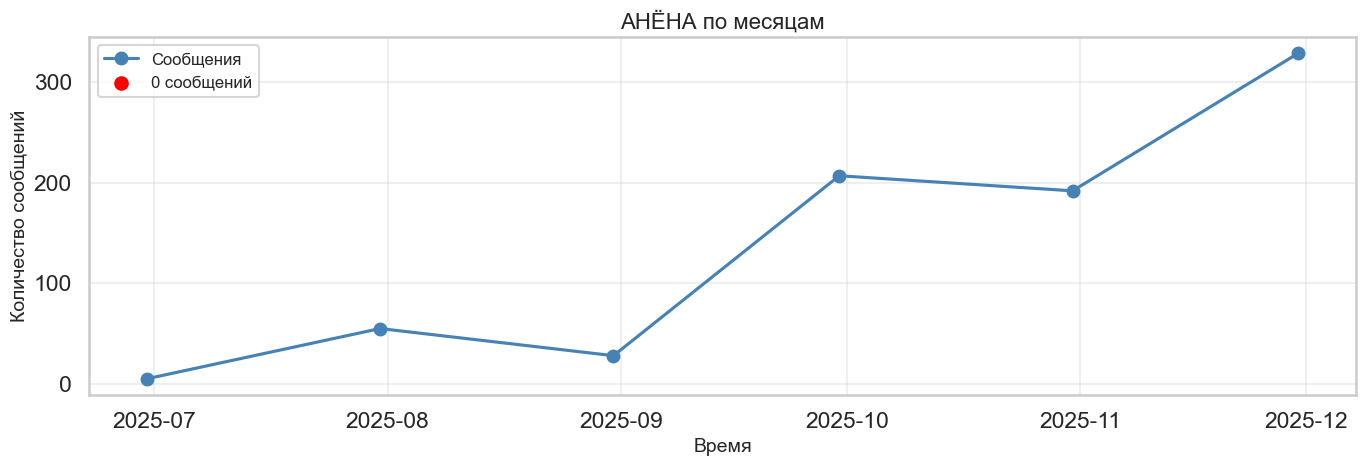

************
*** паша ***
************


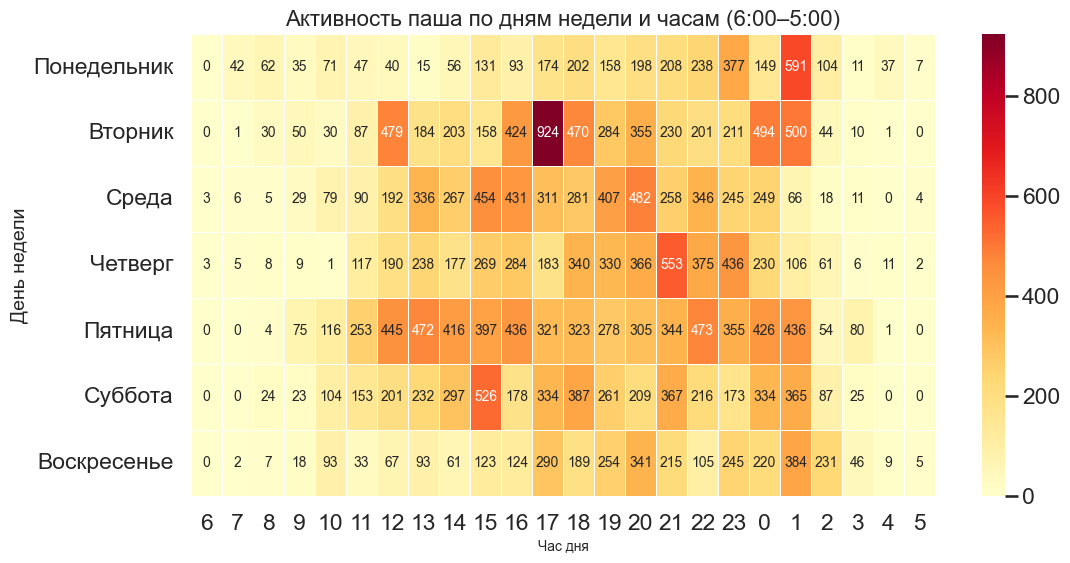

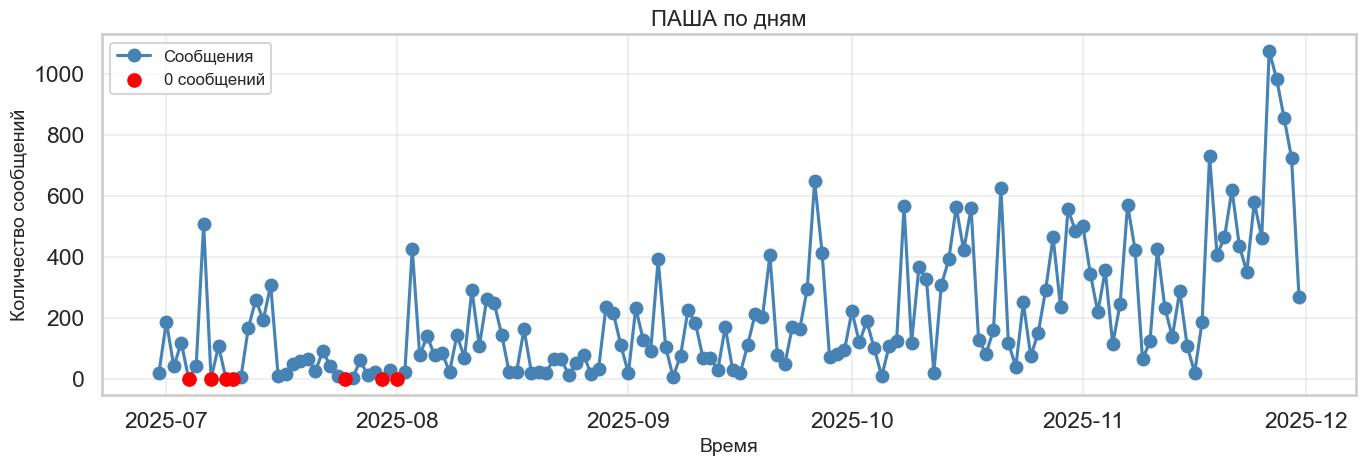

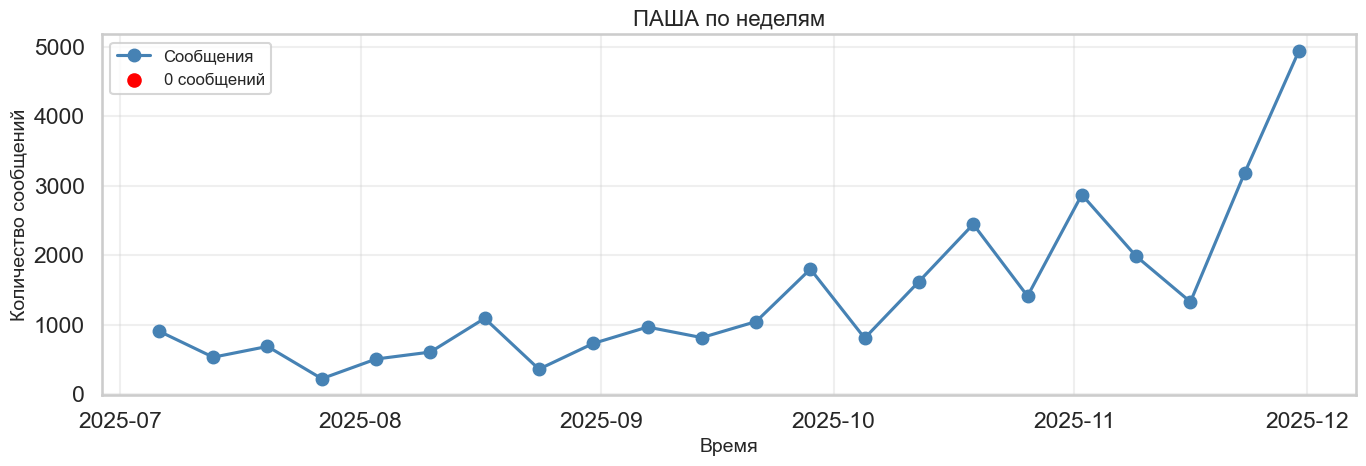

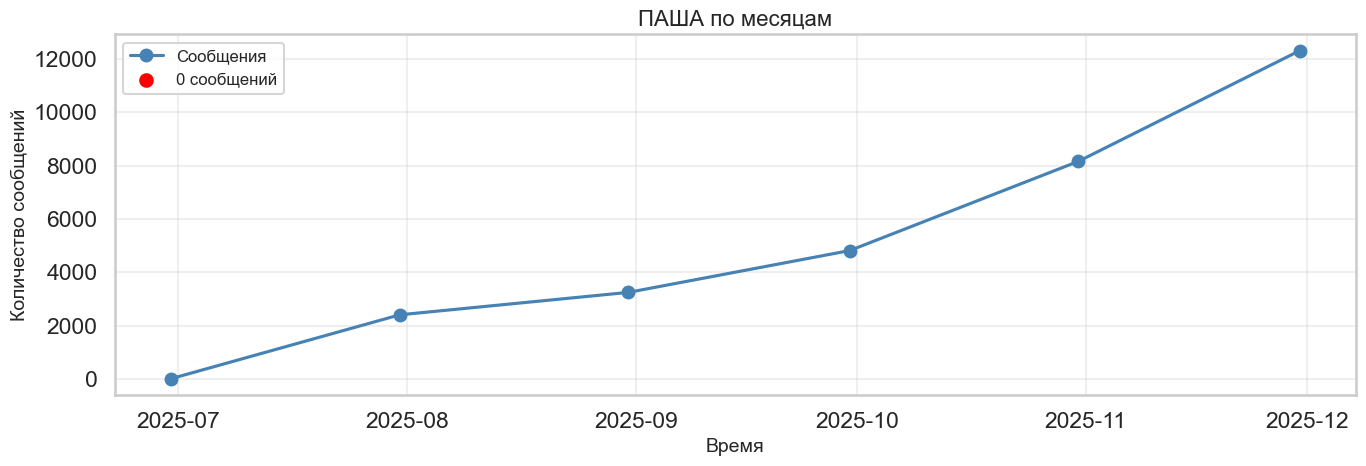

In [18]:
def plot_user_activity(df_user, freq, title):
    sns.set_style("whitegrid")
    sns.set_context("talk")

    counts = df_user.resample(freq, on='date').size()

    plt.figure(figsize=(14, 5))
    plt.plot(counts.index, counts.values, marker='o', linestyle='-', color='steelblue', label='Сообщения')

    # точки с нулями красным
    zero_mask = counts == 0
    plt.scatter(counts.index[zero_mask], counts.values[zero_mask], color='red', zorder=5, label='0 сообщений')

    plt.title(title, fontsize=16)
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Количество сообщений', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


users = ['Мотюша', 'Никита', 'Илья Бибизянов', 'Няма Нямочкин', 'ТимохаПро', 'Анёна', 'паша']
days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
hours_order = list(range(6, 24)) + list(range(0, 6))

for user in users:
    print('*' * (len(user) + 8))
    print(f'*** {user} ***')
    print('*' * (len(user) + 8))

    df_user = df[df['from'] == user]

    # Тепловая карта по дням недели и часам с сдвигом
    heat_data = df_user.groupby(['weekday_ru', 'hour']).size().unstack(fill_value=0)

    # Порядок дней недели
    heat_data = heat_data.reindex(days_order)

    # Порядок часов с 6 до 5, добавляем недостающие столбцы с нулями
    heat_data = heat_data.reindex(columns=hours_order, fill_value=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heat_data,
        cmap='YlOrRd',
        linewidths=.5,
        annot=True,
        fmt='d',
        annot_kws={"size": 10}  # уменьшенный шрифт цифр
    )
    plt.title(f'Активность {user} по дням недели и часам (6:00–5:00)', fontsize=16)
    plt.xlabel('Час дня', fontsize=10)
    plt.ylabel('День недели', fontsize=14)
    plt.show()

    plot_user_activity(df_user, 'D', f'{user.upper()} по дням')
    plot_user_activity(df_user, 'W', f'{user.upper()} по неделям')
    plot_user_activity(df_user, 'ME', f'{user.upper()} по месяцам')